In [ ]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Quantum transfer learning {#quantum_transfer_learning}
=========================

::: {.meta}
:property=\"og:description\": Combine PyTorch and PennyLane to train a
hybrid quantum-classical image classifier using transfer learning.
:property=\"og:image\":
<https://pennylane.ai/qml/_images/transfer_images.png>
:::

*Author: Andrea Mari --- Posted: 19 December 2019. Last updated: 28
January 2021.*

In this tutorial we apply a machine learning method, known as *transfer
learning*, to an image classifier based on a hybrid classical-quantum
network.

This example follows the general structure of the PyTorch [tutorial on
transfer
learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
by Sasank Chilamkurthy, with the crucial difference of using a quantum
circuit to perform the final classification task.

More details on this topic can be found in the research paper \[1\]
([Mari et al. (2019)](https://arxiv.org/abs/1912.08278)).

Introduction
------------

Transfer learning is a well-established technique for training
artificial neural networks (see e.g., Ref. \[2\]), which is based on the
general intuition that if a pre-trained network is good at solving a
given problem, then, with just a bit of additional training, it can be
used to also solve a different but related problem.

As discussed in Ref. \[1\], this idea can be formalized in terms of two
abstract networks $A$ and $B$, independently from their quantum or
classical physical nature.

| 

![](../demonstrations/quantum_transfer_learning/transfer_learning_general.png){.align-center}

| 

As sketched in the above figure, one can give the following **general
definition of the transfer learning method**:

1.  Take a network $A$ that has been pre-trained on a dataset $D_A$ and
    for a given task $T_A$.
2.  Remove some of the final layers. In this way, the resulting
    truncated network $A'$ can be used as a feature extractor.
3.  Connect a new trainable network $B$ at the end of the pre-trained
    network $A'$.
4.  Keep the weights of $A'$ constant, and train the final block $B$
    with a new dataset $D_B$ and/or for a new task of interest $T_B$.

When dealing with hybrid systems, depending on the physical nature
(classical or quantum) of the networks $A$ and $B$, one can have
different implementations of transfer learning as

summarized in following table:

| 

::: {.rst-class}
docstable
:::

  -------------------------------------------------------------------------
  Network A   Network B   Transfer learning scheme
  ----------- ----------- -------------------------------------------------
  Classical   Classical   CC - Standard classical method. See e.g., Ref.
                          \[2\].

  Classical   Quantum     CQ - **Hybrid model presented in this tutorial.**

  Quantum     Classical   QC - Model studied in Ref. \[1\].

  Quantum     Quantum     QQ - Model studied in Ref. \[1\].
  -------------------------------------------------------------------------

Classical-to-quantum transfer learning
--------------------------------------

We focus on the CQ transfer learning scheme discussed in the previous
section and we give a specific example.

1.  As pre-trained network $A$ we use **ResNet18**, a deep residual
    neural network introduced by Microsoft in Ref. \[3\], which is
    pre-trained on the *ImageNet* dataset.
2.  After removing its final layer we obtain $A'$, a pre-processing
    block which maps any input high-resolution image into 512 abstract
    features.
3.  Such features are classified by a 4-qubit \"dressed quantum
    circuit\" $B$, i.e., a variational quantum circuit sandwiched
    between two classical layers.
4.  The hybrid model is trained, keeping $A'$ constant, on the
    *Hymenoptera* dataset (a small subclass of ImageNet) containing
    images of *ants* and *bees*.

A graphical representation of the full data processing pipeline is given
in the figure below.

![](../demonstrations/quantum_transfer_learning/transfer_learning_c2q.png){.align-center}


General setup
=============

::: {.note}
::: {.title}
Note
:::

To use the PyTorch interface in PennyLane, you must first [install
PyTorch](https://pytorch.org/get-started/locally/#start-locally).
:::

In addition to *PennyLane*, we will also need some standard *PyTorch*
libraries and the plotting library *matplotlib*.


In [ ]:
# Some parts of this code are based on the Python script:
# https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py
# License: BSD

import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

Setting of the main hyper-parameters of the model
=================================================

::: {.note}
::: {.title}
Note
:::

To reproduce the results of Ref. \[1\], `num_epochs` should be set to
`30` which may take a long time. We suggest to first try with
`num_epochs=1` and, if everything runs smoothly, increase it to a larger
value.
:::


In [ ]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4             # Number of samples for each training step
num_epochs = 3              # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

We initialize a PennyLane device with a `default.qubit` backend.


In [ ]:
dev = qml.device("default.qubit", wires=n_qubits)

We configure PyTorch to use CUDA only if available. Otherwise the CPU is
used.


In [ ]:
device = torch.device("cpu")

Dataset loading
===============

::: {.note}
::: {.title}
Note
:::

The dataset containing images of *ants* and *bees* can be downloaded
[here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and
should be extracted in the subfolder `../_data/hymenoptera_data`.
:::

This is a very small dataset (roughly 250 images), too small for
training from scratch a classical or quantum model, however it is enough
when using *transfer learning* approach.

The PyTorch packages `torchvision` and `torch.utils.data` are used for
loading the dataset and performing standard preliminary image
operations: resize, center, crop, normalize, *etc.*


In [ ]:
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "/content/drive/MyDrive/Colab Notebooks/hymenoptera_data"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

Let us show a batch of the test data, just to have an idea of the
classification problem.


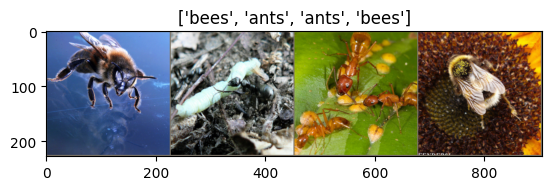

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

Variational quantum circuit
===========================

We first define some quantum layers that will compose the quantum
circuit.


In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def RX_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RX(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

Now we define the quantum circuit through the PennyLane
[qnode]{.title-ref} decorator .

The structure is that of a typical variational quantum circuit:

-   **Embedding layer:** All qubits are first initialized in a balanced
    superposition of *up* and *down* states, then they are rotated
    according to the input parameters (local embedding).
-   **Variational layers:** A sequence of trainable rotation layers and
    constant entangling layers is applied.
-   **Measurement layer:** For each qubit, the local expectation value
    of the $Z$ operator is measured. This produces a classical output
    vector, suitable for additional post-processing.


In [ ]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat, entropy_train_weights1, entropy_train_weights2):

    
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
   
    RY_layer(q_input_features)

    RY_layer(entropy_train_weights1)
    
    RX_layer(entropy_train_weights2)

   

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis


    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)   

In [ ]:
@qml.qnode(dev, interface="torch")
def quantum_net1(q_input_features, q_weights_flat, entropy_train_weights1, entropy_train_weights2):

    
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node

    RY_layer(q_input_features)
   
    RY_layer(entropy_train_weights1)

    RX_layer(entropy_train_weights2)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis


    exp_vals= qml.density_matrix([1])
    return (exp_vals)   

Dressed quantum circuit
=======================

We can now define a custom `torch.nn.Module` representing a *dressed*
quantum circuit.

This is a concatenation of:

-   A classical pre-processing layer (`nn.Linear`).
-   A classical activation function (`torch.tanh`).
-   A constant `np.pi/2.0` scaling.
-   The previously defined quantum circuit (`quantum_net`).
-   A classical post-processing layer (`nn.Linear`).

The input of the module is a batch of vectors with 512 real parameters
(features) and the output is a batch of vectors with two real outputs
(associated with the two classes of images: *ants* and *bees*).


In [ ]:
from os import posix_spawn
, unsqueeze
from pennylane.math.utils import requires_grad
import matplotlib.pyplot as plt
import pennylane as qml 
import torch
from torch.autograd import Variable
from pennylane import numpy as np

# Create a random seed
np.random.seed(67)
torch.manual_seed(42)


# Calculate second Renyi entanglement entropy using our weights and random parameters

def calculate_entropy(phi, theta, psi, alpha):
  
  density_matrix=(quantum_net1(phi, theta, psi, alpha))
  entropy=-torch.log2(torch.trace(density_matrix**2))
  return entropy

# Calculate cost function using entanglement entropy and target value of entanglement entropy
def cost(entropy, target):
  return torch.abs(entropy-target)**2


target=torch.tensor(0.1)


epoch=200

def entropy_train_model(phi, theta, psi, alpha):
  
  opt = torch.optim.Adam([psi,  alpha], lr = 0.1)
  
  for i in range(epoch):
      opt.zero_grad()
      
      entropy = calculate_entropy(phi[i], theta, psi, alpha)
      loss = cost(entropy, target)
      if i % 20 == 0:
        print(f"Entropy= {entropy} | Loss= {loss}")
      
      loss.backward() 
      opt.step()
     
  return psi , alpha



In [ ]:
inputs1 = torch.rand(epoch,4)#.unsqueeze(0)
inputs2 = torch.rand(1,24)

psi = Variable(torch.rand(1,4)).squeeze()
psi = torch.tensor(psi, requires_grad=True)

alpha = Variable(torch.rand(1,4)).squeeze()
alpha = torch.tensor(alpha, requires_grad=True)


params1, params2 = entropy_train_model(inputs1, inputs2, psi, alpha)



<ipython-input-714-539a5cbe9006>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psi = torch.tensor(psi, requires_grad=True)
<ipython-input-714-539a5cbe9006>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(alpha, requires_grad=True)


Entropy= (0.9050404202268977-0j) | Loss= 0.6480900757998926
Entropy= (0.3081957463378453-0j) | Loss= 0.043345468172700755
Entropy= (0.3099882555158966-0j) | Loss= 0.04409506682879571
Entropy= (0.3530648156101726-0j) | Loss= 0.06404180014561875
Entropy= (0.2884985382691397-0j) | Loss= 0.0355316983678329
Entropy= (0.3136030804738583-0j) | Loss= 0.04562627535133481
Entropy= (0.3144850162149338-0j) | Loss= 0.04600382154150526
Entropy= (0.37764289138522855-0j) | Loss= 0.07708557430930953
Entropy= (0.4179903895048094-0j) | Loss= 0.10111788686973518
Entropy= (0.33084582158319353-0j) | Loss= 0.053289792654445466


In [ ]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        #print(input_features.size())
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
       
        params1 = torch.tensor([0.7074, 0.0744, 0.2932, 0.6632])
        params2 = torch.tensor([-0.0443, -0.4603,  0.7308,  0.6684])
        #q_in = q_in.clone().detach().requires_grad_(True)
        #params = entropy_train_model(q_in, self.q_params)        
        

        for elem in  (q_in):
          
            q_out_elem = quantum_net(elem, self.q_params, params1, params2).float().unsqueeze(0)          
            
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

Hybrid classical-quantum model
==============================

We are finally ready to build our full hybrid classical-quantum network.
We follow the *transfer learning* approach:

1.  First load the classical pre-trained network *ResNet18* from the
    `torchvision.models` zoo.
2.  Freeze all the weights since they should not be trained.
3.  Replace the last fully connected layer with our trainable dressed
    quantum circuit (`DressedQuantumNet`).

::: {.note}
::: {.title}
Note
:::

The *ResNet18* model is automatically downloaded by PyTorch and it may
take several minutes (only the first time).
:::


In [ ]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training and results
====================

Before training the network we need to specify the *loss* function.

We use, as usual in classification problem, the *cross-entropy* which is
directly available within `torch.nn`.


In [ ]:
criterion = nn.CrossEntropyLoss()

We also initialize the *Adam optimizer* which is called at each training
step in order to update the weights of the model.


In [ ]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

We schedule to reduce the learning rate by a factor of
`gamma_lr_scheduler` every 10 epochs.


In [ ]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

What follows is a training function that will be called later. This
function should return a trained model that can be used to make
predictions (classifications).


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            print(phase)
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                
                since_batch = time.time()
                batch_size_ = len(inputs)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    #params = entropy_train_model(inputs1, inputs2, psi)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss
      
            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model

We are ready to perform the actual training process.


In [ ]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:
train


<ipython-input-716-8bfae3d1172a>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psi = torch.tensor(psi, requires_grad=True)
<ipython-input-716-8bfae3d1172a>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(alpha, requires_grad=True)


Entropy= (0.9968674966260074-0j) | Loss= 0.8043713038313279
Entropy= (0.3945222019594145-0j) | Loss= 0.08674332656927759
Entropy= (0.40265756328121155-0j) | Loss= 0.09160159970933075
Entropy= (0.3711889544933257-0j) | Loss= 0.073543448230977
Entropy= (0.2521607236881796-0j) | Loss= 0.023152885379836247
Entropy= (0.36618602545291423-0j) | Loss= 0.07085499935312334
Entropy= (0.1546800747215876-0j) | Loss= 0.0029899104085990835
Entropy= (0.1771549694596121-0j) | Loss= 0.00595288908237395
Entropy= (0.19100610821816888-0j) | Loss= 0.00828211146179773
Entropy= (0.3025793508030331-0j) | Loss= 0.04103839276804484
Entropy= (0.9956837791270928-0j) | Loss= 0.8022494295220451
Entropy= (0.6374602753467311-0j) | Loss= 0.2888635459740276
Entropy= (0.3284916497448763-0j) | Loss= 0.05220843332217706
Entropy= (0.21327143672479149-0j) | Loss= 0.012830418040123257
Entropy= (0.20337935795392664-0j) | Loss= 0.010687291342871602
Entropy= (0.3797955410780855-0j) | Loss= 0.07828554397332294
Entropy= (0.2457116

RuntimeError: ignored

Visualizing the model predictions
=================================


We first define a visualization function for a batch of test data.


In [ ]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

Finally, we can run the previous function to see a batch of images with
the corresponding predictions.


In [ ]:
visualize_model(model_hybrid, num_images=batch_size)
plt.show()